In [78]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


**LOAD DATA**

In [79]:
df = pd.read_csv('/content/data_cluster_netflix.csv')
df.head()
display(df.head())
print(f'data sebelum dibersihkan', df.isnull().sum())

,show_id,type,title,directors,cast,countries,date_added,release_year,rating,duration,listed_in,description
0,s8,Movie,Sankofa,Haile Gerima,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...","United States, Ghana, Burkina Faso, United Kin...","September 24, 2021",1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies","On a photo shoot in Ghana, an American model s..."
1,s9,TV Show,The Great British Baking Show,Andy Devonshire,"Mel Giedroyc, Sue Perkins, Mary Berry, Paul Ho...",United Kingdom,"September 24, 2021",2021,TV-14,9 Seasons,"British TV Shows, Reality TV",A talented batch of amateur bakers face off in...
2,s10,Movie,The Starling,Theodore Melfi,"Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...",United States,"September 24, 2021",2021,PG-13,104 min,"Comedies, Dramas",A woman adjusting to life after a loss contend...
3,s13,Movie,Je Suis Karl,Christian Schwochow,"Luna Wedler, Jannis Niewöhner, Milan Peschel, ...","Germany, Czech Republic","September 23, 2021",2021,TV-MA,127 min,"Dramas, International Movies",After most of her family is murdered in a terr...
4,s25,Movie,Jeans,S. Shankar,"Prashanth, Aishwarya Rai Bachchan, Sri Lakshmi...",India,"September 21, 2021",1998,TV-14,166 min,"Comedies, International Movies, Romantic Movies",When the father of the man she loves insists t...


data sebelum dibersihkan show_id         0
type            0
title           0
directors       0
cast            0
countries       0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64


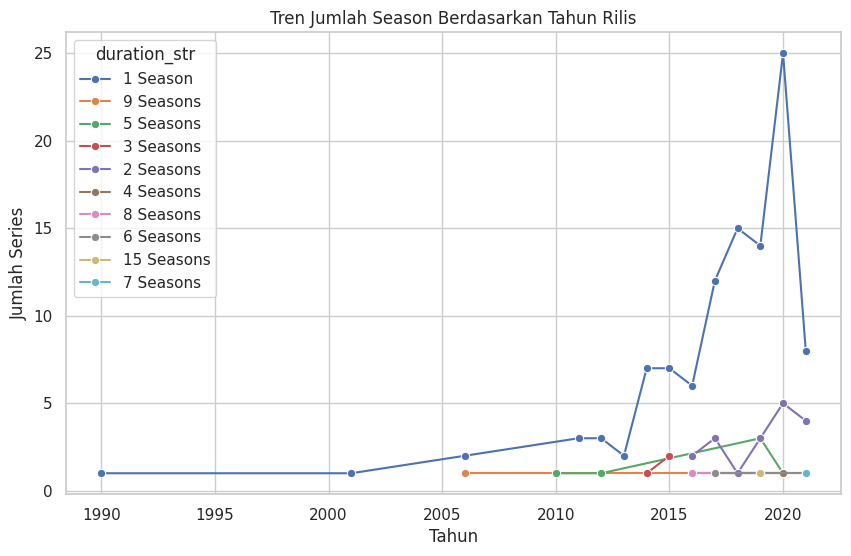

In [80]:
# Simpan versi string durasi
data['duration_str'] = data['duration'].astype(str)

# Filter yang ada 'Season'
season_counts = (
    data[data['duration_str'].str.contains('Season', na=False)]
    .groupby(['release_year', 'duration_str'])
    .size()
    .reset_index(name='count')
)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.lineplot(data=season_counts, x='release_year', y='count', hue='duration_str', marker='o')
plt.title('Tren Jumlah Season Berdasarkan Tahun Rilis')
plt.xlabel('Tahun')
plt.ylabel('Jumlah Series')
plt.grid(True)
plt.show()


In [81]:
df.to_csv('data_cluster_netflix.csv', index=False)#menyimpan data dalam bentuk csv

**MEMBUAT CLUSTER DENGAN** *K-MEANS*

Jumlah data per cluster:
cluster
2    1879
3    1015
0     902
1     392
4     354
Name: count, dtype: int64

Rata-rata fitur numerik per cluster:
         duration_num  release_year
cluster                            
0          102.360310   2013.500000
1          108.112245   2012.140306
2           95.883449   2016.631187
3          109.531034   2015.148768
4           99.822034   2015.338983


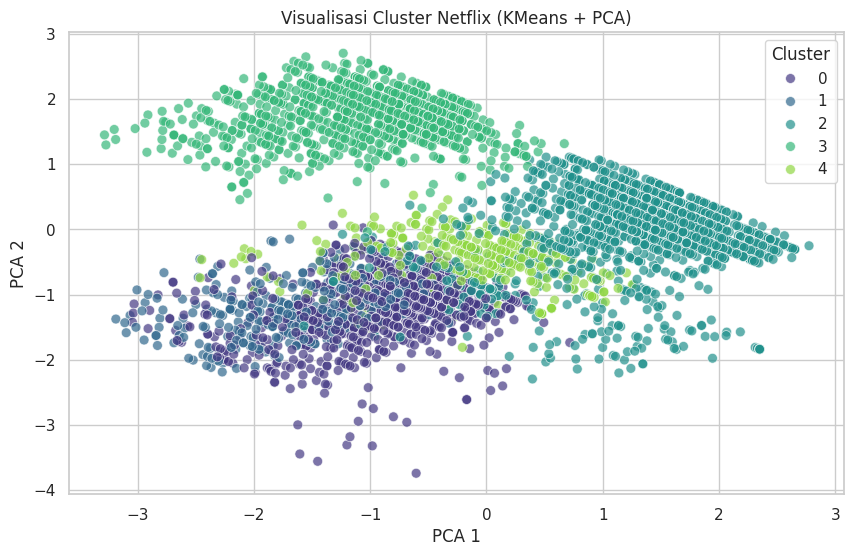

In [82]:
#KONVERSI DURASI
def convert_duration(x):
    if pd.isnull(x):
        return np.nan
    if 'min' in x:
        return int(x.replace(' min',''))
    elif 'Season' in x:
        return int(x.split()[0])
    else:
        return np.nan

df['duration_num'] = df['duration'].apply(convert_duration)

#HAPUS OUTLIER (IQR)
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

df = remove_outliers_iqr(df, 'duration_num')
df = remove_outliers_iqr(df, 'release_year')

#ENCODE TYPE DAN RATING (ONE-HOT)
type_ohe = pd.get_dummies(df['type'], prefix='type')

#Rating
rating_ohe = pd.get_dummies(df['rating'], prefix='rating')

#Gabungkan semua fitur
features = pd.concat([df[['duration_num', 'release_year']], type_ohe, rating_ohe], axis=1)

#Standarisasi fitur numerik
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

#KMEANS CLUSTERING
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(features_scaled)

#ANALISIS CLUSTER
print("Jumlah data per cluster:")
print(df['cluster'].value_counts())

print("\nRata-rata fitur numerik per cluster:")
print(df.groupby('cluster')[['duration_num', 'release_year']].mean())

#VISUALISASI PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(features_scaled)

plt.figure(figsize=(10,6))
palette = sns.color_palette('viridis', n_colors=5)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['cluster'], palette=palette, s=50, alpha=0.7)
plt.title('Visualisasi Cluster Netflix (KMeans + PCA)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster')
plt.show()

In [83]:
!pip install -U streamlit pyngrok --no-deps



In [84]:
#Jalankan aplikasi Streamlit di background
!streamlit run app.py &>/content/logs.txt &

#hubungkan grok
from pyngrok import ngrok
ngrok.kill()

public_url = ngrok.connect(addr="8501", proto="http", bind_tls=True)

print("aplikasi Streamlit")
print(public_url)

aplikasi Streamlit
NgrokTunnel: "https://nonhierarchically-preindependent-estelle.ngrok-free.dev" -> "http://localhost:8501"
